# **Classification Prediction Model**
#### *Case Study: Telco Customer Churn*
##### Data Scientist: Zacharia Bachtiar

## **Business Problem Understanding**

**Context**  

Sebuah perusahaan telekomunikasi bertanggung jawab dalam membangun infrastruktur yang memungkinkan komunikasi terjadi dalam skala global. Perusahaan telekomunikasi juga harus memastikan kepuasan customer mereka agar tetap menggunakan layanan yang ditawarkan. 

Salah satu tantangan utama yang dihadapi perusahaan ini adalah churn, yaitu ketika customer berhenti berlangganan dan beralih ke penyedia layanan lain. Upaya retensi menjadi hal yang harus diprioritaskan karena biaya akuisisi customer baru seringkali lebih besar dibandingkan biaya retensi customer (bisa 5-25 kali lebih mahal).

Telco, yang merupakan sebuah perusahaan telekomunikasi, ingin mengetahui customer mana yang akan churn atau tidak.

Referensi: https://hbr.org/2014/10/the-value-of-keeping-the-right-customers

**Target**

- Tidak Churn : 0
- Churn : 1

**Problem Statement**

Proses akuisisi customer baru seringkali memakan waktu dan biaya yang jauh lebih besar dibandingkan dengan mempertahankan customer yang sudah dimiliki. **Divisi Business Development** Telco ingin mengurangi *aquisition cost* dengan cara mengurangi tingkat churn customer. Identifikasi customer mana yang akan churn dapat memberikan insights pada perusahaan terkait customer mana yang perlu diberikan upaya retensi.

**Goals**

Jika diasumsikan bahwa data yang digunakan merupakan data 1 bulan sebelum customer tersebut churn atau tidak, perusahaan ingin suatu kapabilitas untuk melakukan prediksi apakah seorang customer akan churn atau tidak 1 bulan kedepan. Dengan informasi tersebut, perusahaan dapat melakukan upaya retensi customer yang bersifat `target-based`. 

Upaya ini memungkinkan perusahaan untuk mempertahankan customer yang diprediksi akan churn, tetapi juga tepat sasaran dan tidak asal memberikan upaya.

**Analytic Approach :**

Sebagai data scientist untuk perusahaan Telco, saya akan melakukan pengembangan model klasifikasi yang akan membantu perusahaan dalam memprediksi probabilitas customer yang akan churn atau tidak. 

Dalam proses pengembangan juga dapat ditemukan pola yang membedakan antara customer yang akan churn dan customer yang tidak churn.

**Metric Evaluation :**

- **Type 1 Error : False Positive**

    Metrik ini menggambarkan customer yang diprediksi akan churn tetapi sebenarnya tidak churn. Konsekuensi dari hal ini adalah terbuangnya upaya retensi pada customer yang seharusnya tidak diberikan upaya tersebut.

- **Type 2 Error : False Negative**

    Metrik ini menggambarkan customer yang diprediksi tidak churn tetapi sebenarnya churn. Konsekuensi dari hal ini adalah terbuangnya customer berharga sehingga mengharuskan perusahaan untuk mengeluarkan upaya lebih untuk akuisisi customer baru.

Fokus pada model ini adalah mengurangi **False Negative** karena dampak dari kehilangan customer yang berharga lebih merugikan perusahaan dibandingkan dengan memberikan upaya retensi yang sia-sia kepada customer yang tidak churn.

## **Data Understanding**

In [1]:
# Import Library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#normality
import scipy.stats as stats

#scaler
from sklearn.preprocessing import MinMaxScaler

#encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#feature_selection
from sklearn.feature_selection import SelectKBest, f_classif
#resampling
from imblearn.over_sampling import SMOTE

#tuning model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, recall_score

#pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


None

> Notes:
> - Dataset berisi data historis profil pelanggan yang churn / tidak churn dari Telco.
> - Dataset memiliki data sebanyak 4930 baris.
> - 80% dari fitur pada data berupa tipe object 

| Fitur             | Deskripsi                                                   |
|-------------------|-------------------------------------------------------------|
| Dependents        | Apakah pelanggan memiliki tanggungan atau tidak             |
| Tenure            | Durasi pelanggan telah berlangganan dengan perusahaan  (dalam bulan)   |
| OnlineSecurity    | Apakah pelanggan memiliki keamanan online atau tidak        |
| OnlineBackup      | Apakah pelanggan memiliki backup online atau tidak        |
| InternetService   | Apakah pelanggan berlangganan layanan internet atau tidak   |
| DeviceProtection  | Apakah pelanggan memiliki perlindungan perangkat atau tidak |
| TechSupport       | Apakah pelanggan memiliki dukungan teknis atau tidak        |
| Contract          | Jenis kontrak berdasarkan durasi                            |
| PaperlessBilling  | Tagihan diterbitkan dalam bentuk tanpa kertas               |
| MonthlyCharges    | Jumlah biaya layanan per bulan                              |
| Churn             | Apakah pelanggan churn atau tidak                          |


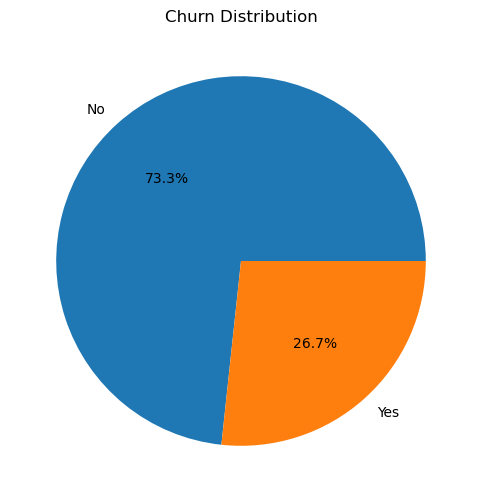

Churn
No     3614
Yes    1316
Name: count, dtype: int64

In [3]:
churn_counts = df['Churn'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%')
plt.title('Churn Distribution')
plt.show()

display(churn_counts)

> Notes:
> - Dataset bersifat imbalance atau tidak seimbang, dengan rasio customer churn dan tidak churn sekitar 1:3.

## **Data Preparation**

#### **Encode Target/Label**

In [4]:
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)
df['Churn'].sample(5)

4643    1
331     0
706     0
3942    0
1463    0
Name: Churn, dtype: int64

> Notes:
> - Label atau target dari data yaitu fitur 'Churn' di-encode menjadi (0-1).

#### **Handle Missing Values**

In [5]:
missing_data = []
for i in df.columns :
    missing_data.append([
        i,
        df[i].dtype,
        round(df[i].isna().sum()/len(df[i])*100, 3),
        df[i].isna().sum(),
        df[i].nunique(),
        df[i].unique()[:3]
    ])


info_df = pd.DataFrame(missing_data,columns='Feature, Data Type, Missing Value (%), Missing Value, Unique Count, Unique Samples'.split(', '))
info_df

,Feature,Data Type,Missing Value (%),Missing Value,Unique Count,Unique Samples
0,Dependents,object,0.0,0,2,"[Yes, No]"
1,tenure,int64,0.0,0,73,"[9, 14, 64]"
2,OnlineSecurity,object,0.0,0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,0.0,0,3,"[No, Yes, No internet service]"
4,InternetService,object,0.0,0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,0.0,0,3,"[Yes, No internet service, No]"
6,TechSupport,object,0.0,0,3,"[Yes, No, No internet service]"
7,Contract,object,0.0,0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,0.0,0,2,"[Yes, No]"
9,MonthlyCharges,float64,0.0,0,1422,"[72.9, 82.65, 47.85]"


> Notes:
> - Tidak terdapat missing value pada dataset.

#### **Handle Inconsistencies**

In [6]:
checkOnlineSecurity = df[df['InternetService'] == 'No']['OnlineSecurity'].value_counts()
checkOnlineBackup = df[df['InternetService'] == 'No']['OnlineBackup'].value_counts()
checkDeviceProtection = df[df['InternetService'] == 'No']['DeviceProtection'].value_counts()
checkTechSupport = df[df['InternetService'] == 'No']['TechSupport'].value_counts()

display(checkOnlineSecurity, checkOnlineBackup, checkDeviceProtection, checkTechSupport)

OnlineSecurity
No internet service    1052
Name: count, dtype: int64

OnlineBackup
No internet service    1052
Name: count, dtype: int64

DeviceProtection
No internet service    1052
Name: count, dtype: int64

TechSupport
No internet service    1052
Name: count, dtype: int64

> Notes:
> - Tidak terdapat data yang inkonsisten.
> - Terdapat 4 fitur yang bergantung pada fitur `InternetService`, jika tidak berlangganan internet maka keempat fitur tersebut harus memiliki value `No internet service`.

#### **Handle Outlier**

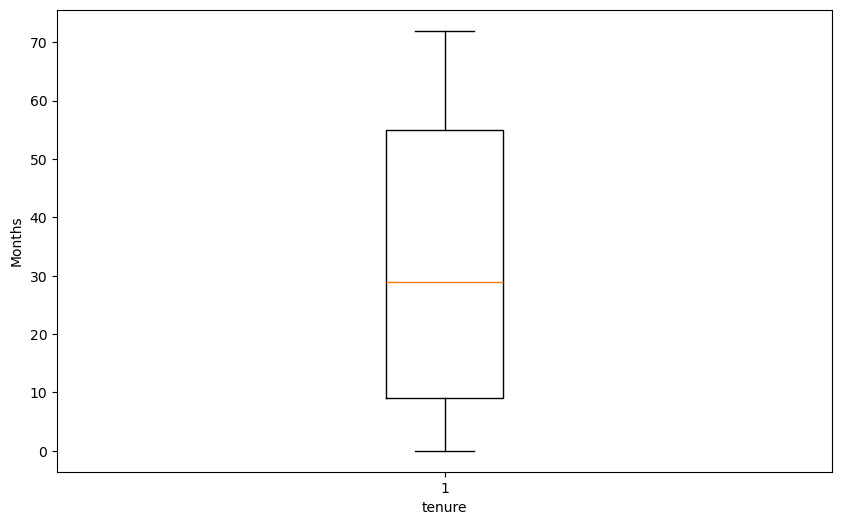

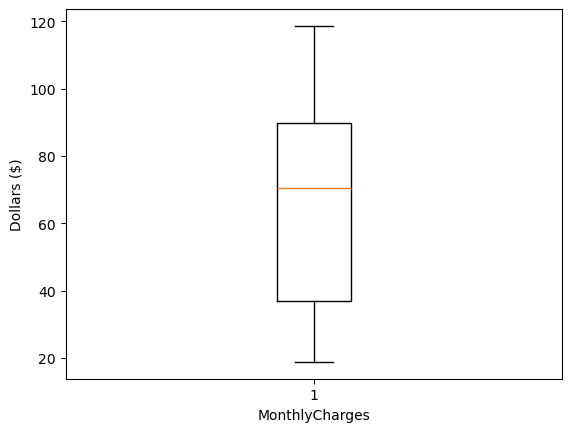

In [7]:
num_features = df.drop('Churn', axis=1).select_dtypes(include='number')
y_axis = ['Months', 'Dollars ($)']

plt.figure(figsize=(10, 6))
for i,j in zip(num_features, y_axis):
    plt.boxplot(df[i])
    plt.xlabel(i)
    plt.ylabel(j)
    plt.show()


> Notes:
> - Tidak terdapat data yang berupa outliers.

#### **Normality Test**

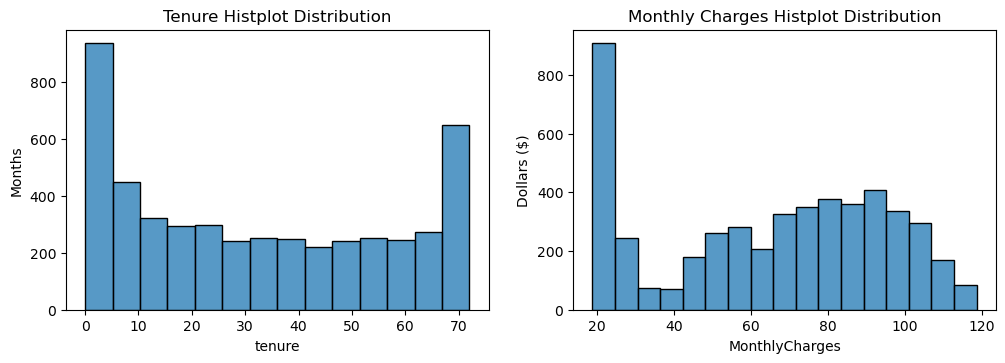

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.histplot(df["tenure"])
plt.title("Tenure Histplot Distribution")
plt.ylabel('Months')

plt.subplot(2,2,2)
sns.histplot(df["MonthlyCharges"])
plt.title("Monthly Charges Histplot Distribution")
plt.ylabel('Dollars ($)')

plt.show()

In [9]:
results = []

def normality_test(data, col_name):
    stat, p_value = stats.normaltest(data)
    is_normal = 'Normal' if p_value > 0.05 else 'Not Normal'
    results.append({'Column': col_name, 'p-value': p_value, 'Normality': is_normal})

for col in df.drop('Churn',axis=1).select_dtypes(include='number'):
    normality_test(df[col], col)

normality_results_df = pd.DataFrame(results)

normality_results_df

,Column,p-value,Normality
0,tenure,0.0,Not Normal
1,MonthlyCharges,0.0,Not Normal


> Notes:
> - Fitur numerik pada dataset tidak terdistribusi normal, sehingga dapat digunakan `Minmax Scaling` (tidak menggunakan `Robust Scaling` karena tidak terdapat outliers yang perlu dihandle).

#### **Feature Engineering**

##### **Bin Tenure**

In [10]:
tenure_quantiles = df['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).values
tenure_labels = ['Short-Term', 'Medium-Term', 'Long-Term', 'Very Long-Term'] 

df['TenureCategory'] = pd.cut(df['tenure'], bins=tenure_quantiles, labels=tenure_labels, include_lowest=True)

df[['tenure', 'TenureCategory']].head()

,tenure,TenureCategory
0,9,Short-Term
1,14,Medium-Term
2,64,Very Long-Term
3,72,Very Long-Term
4,3,Short-Term


| **Fitur**            | **Kategori**        | **Penjelasan**                                                                |
|----------------------|---------------------|-------------------------------------------------------------------------------|
| **Tenure**           | Short-Term          | Pelanggan baru (misalnya, < 6 bulan), lebih rentan terhadap churn, masih dalam tahap eksplorasi. |
|                      | Medium-Term         | Pelanggan dengan masa berlangganan sedang (misalnya, 6 bulan - 1.5 tahun), sedang mengembangkan loyalitas. |
|                      | Long-Term           | Pelanggan jangka panjang (misalnya, 1.5 - 3 tahun), lebih loyal tapi butuh terus dilibatkan. |
|                      | Very Long-Term      | Pelanggan paling loyal (misalnya, > 3 tahun), nilai seumur hidup tinggi, sangat penting untuk dipertahankan. |


##### **Bin MonthlyCharges**

In [11]:
quantiles = df['MonthlyCharges'].quantile([0, 0.25, 0.5, 0.75, 1]).values
labels = ['Low', 'Medium', 'High', 'Very High']

df['ChargesCategory'] = pd.cut(df['MonthlyCharges'], bins=quantiles, labels=labels, include_lowest=True)

df[['MonthlyCharges', 'ChargesCategory']].head()

,MonthlyCharges,ChargesCategory
0,72.90,High
1,82.65,High
2,47.85,Medium
3,69.65,Medium
4,23.60,Low


| **Fitur**            | **Kategori**        | **Penjelasan**                                                                |
|----------------------|---------------------|-------------------------------------------------------------------------------|
| **MonthlyCharges**    | Low                 | Mewakili pelanggan dengan pengeluaran paling rendah, kemungkinan hanya menggunakan layanan minimal. |
|                      | Medium              | Pelanggan dengan pengeluaran sedang, menggunakan campuran layanan yang seimbang, ada potensi untuk penjualan tambahan. |
|                      | High                | Pelanggan dengan pengeluaran tinggi, menggunakan lebih banyak layanan, mungkin sensitif terhadap perubahan harga. |
|                      | Very High           | Pelanggan dengan pengeluaran tertinggi, kemungkinan pengguna premium, sangat penting untuk strategi retensi. |


> Notes:
>
>Binning digunakan dalam membuat fitur baru agar:
>1. **Menyederhanakan Variabilitas**: Mengubah data numerik seperti `tenure` dan `MonthlyCharges` ke kategori memudahkan interpretasi.
>
>2. **Menangani Distribusi Skewed**: Mengelompokkan data membantu menangkap pola dari **distribusi yang tidak normal**.
>
>3. **Memperbaiki Model**: Dapat mengungkap hubungan **non-linear dengan target**, meningkatkan performa model.

##### **Additional Service Count Feature**

In [12]:
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

df['TotalAdditionalServices'] = df[service_columns].apply(lambda x: sum(x == 'Yes'), axis=1)

df[['InternetService', 'TotalAdditionalServices']].head()

,InternetService,TotalAdditionalServices
0,DSL,2
1,Fiber optic,2
2,DSL,3
3,DSL,4
4,No,0


> Notes:
>
>Feature `TotalAdditionalServices` dibuat untuk menilai keterlibatan pelanggan dengan cara:
>1. **Mengukur Keterlibatan Pelanggan**: Menghitung jumlah layanan yang disubscribe memberikan gambaran jelas tentang seberapa terlibat pelanggan dengan produk perusahaan.
> 
>2. **Indikator Potensial Churn**: Pelanggan yang menggunakan lebih banyak layanan cenderung lebih puas, sehingga jumlah layanan dapat menjadi indikator penting untuk risiko churn.

In [13]:
final_data = []
for i in df.columns :
    final_data.append([
        i,
        df[i].dtype,
        round(df[i].isna().sum()/len(df[i])*100, 3),
        df[i].isna().sum(),
        df[i].nunique(),
        df[i].unique()[:3]
    ])


info_df = pd.DataFrame(final_data,columns='Feature, Data Type, Missing Value (%), Missing Value, Unique Count, Unique Samples'.split(', '))
info_df

,Feature,Data Type,Missing Value (%),Missing Value,Unique Count,Unique Samples
0,Dependents,object,0.0,0,2,"[Yes, No]"
1,tenure,int64,0.0,0,73,"[9, 14, 64]"
2,OnlineSecurity,object,0.0,0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,0.0,0,3,"[No, Yes, No internet service]"
4,InternetService,object,0.0,0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,0.0,0,3,"[Yes, No internet service, No]"
6,TechSupport,object,0.0,0,3,"[Yes, No, No internet service]"
7,Contract,object,0.0,0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,0.0,0,2,"[Yes, No]"
9,MonthlyCharges,float64,0.0,0,1422,"[72.9, 82.65, 47.85]"


## **Data Analysis**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Dependents               4930 non-null   object  
 1   tenure                   4930 non-null   int64   
 2   OnlineSecurity           4930 non-null   object  
 3   OnlineBackup             4930 non-null   object  
 4   InternetService          4930 non-null   object  
 5   DeviceProtection         4930 non-null   object  
 6   TechSupport              4930 non-null   object  
 7   Contract                 4930 non-null   object  
 8   PaperlessBilling         4930 non-null   object  
 9   MonthlyCharges           4930 non-null   float64 
 10  Churn                    4930 non-null   int64   
 11  TenureCategory           4930 non-null   category
 12  ChargesCategory          4930 non-null   category
 13  TotalAdditionalServices  4930 non-null   int64   
dtypes: categ

#### **Numerical Features**

In [15]:
df.drop('Churn',axis=1)[df['Churn'] == 1].describe()

,tenure,MonthlyCharges,TotalAdditionalServices
count,1316.000000,1316.000000,1316.000000
mean,17.674772,74.457637,0.879939
std,19.279312,24.416526,0.982366
min,1.000000,18.850000,0.000000
25%,2.000000,56.437500,0.000000
50%,9.000000,79.700000,1.000000
75%,28.000000,94.200000,1.000000
max,72.000000,118.350000,4.000000


> Notes:
> - Customer yang churn rata-rata berlangganan kurang dari 1 bulan (17 hari).
> - Customer yang churn rata-rata memiliki tagihan bulanan sebesar $74.
> - Customer yang churn rata-rata berlangganan 1 layanan tambahan.

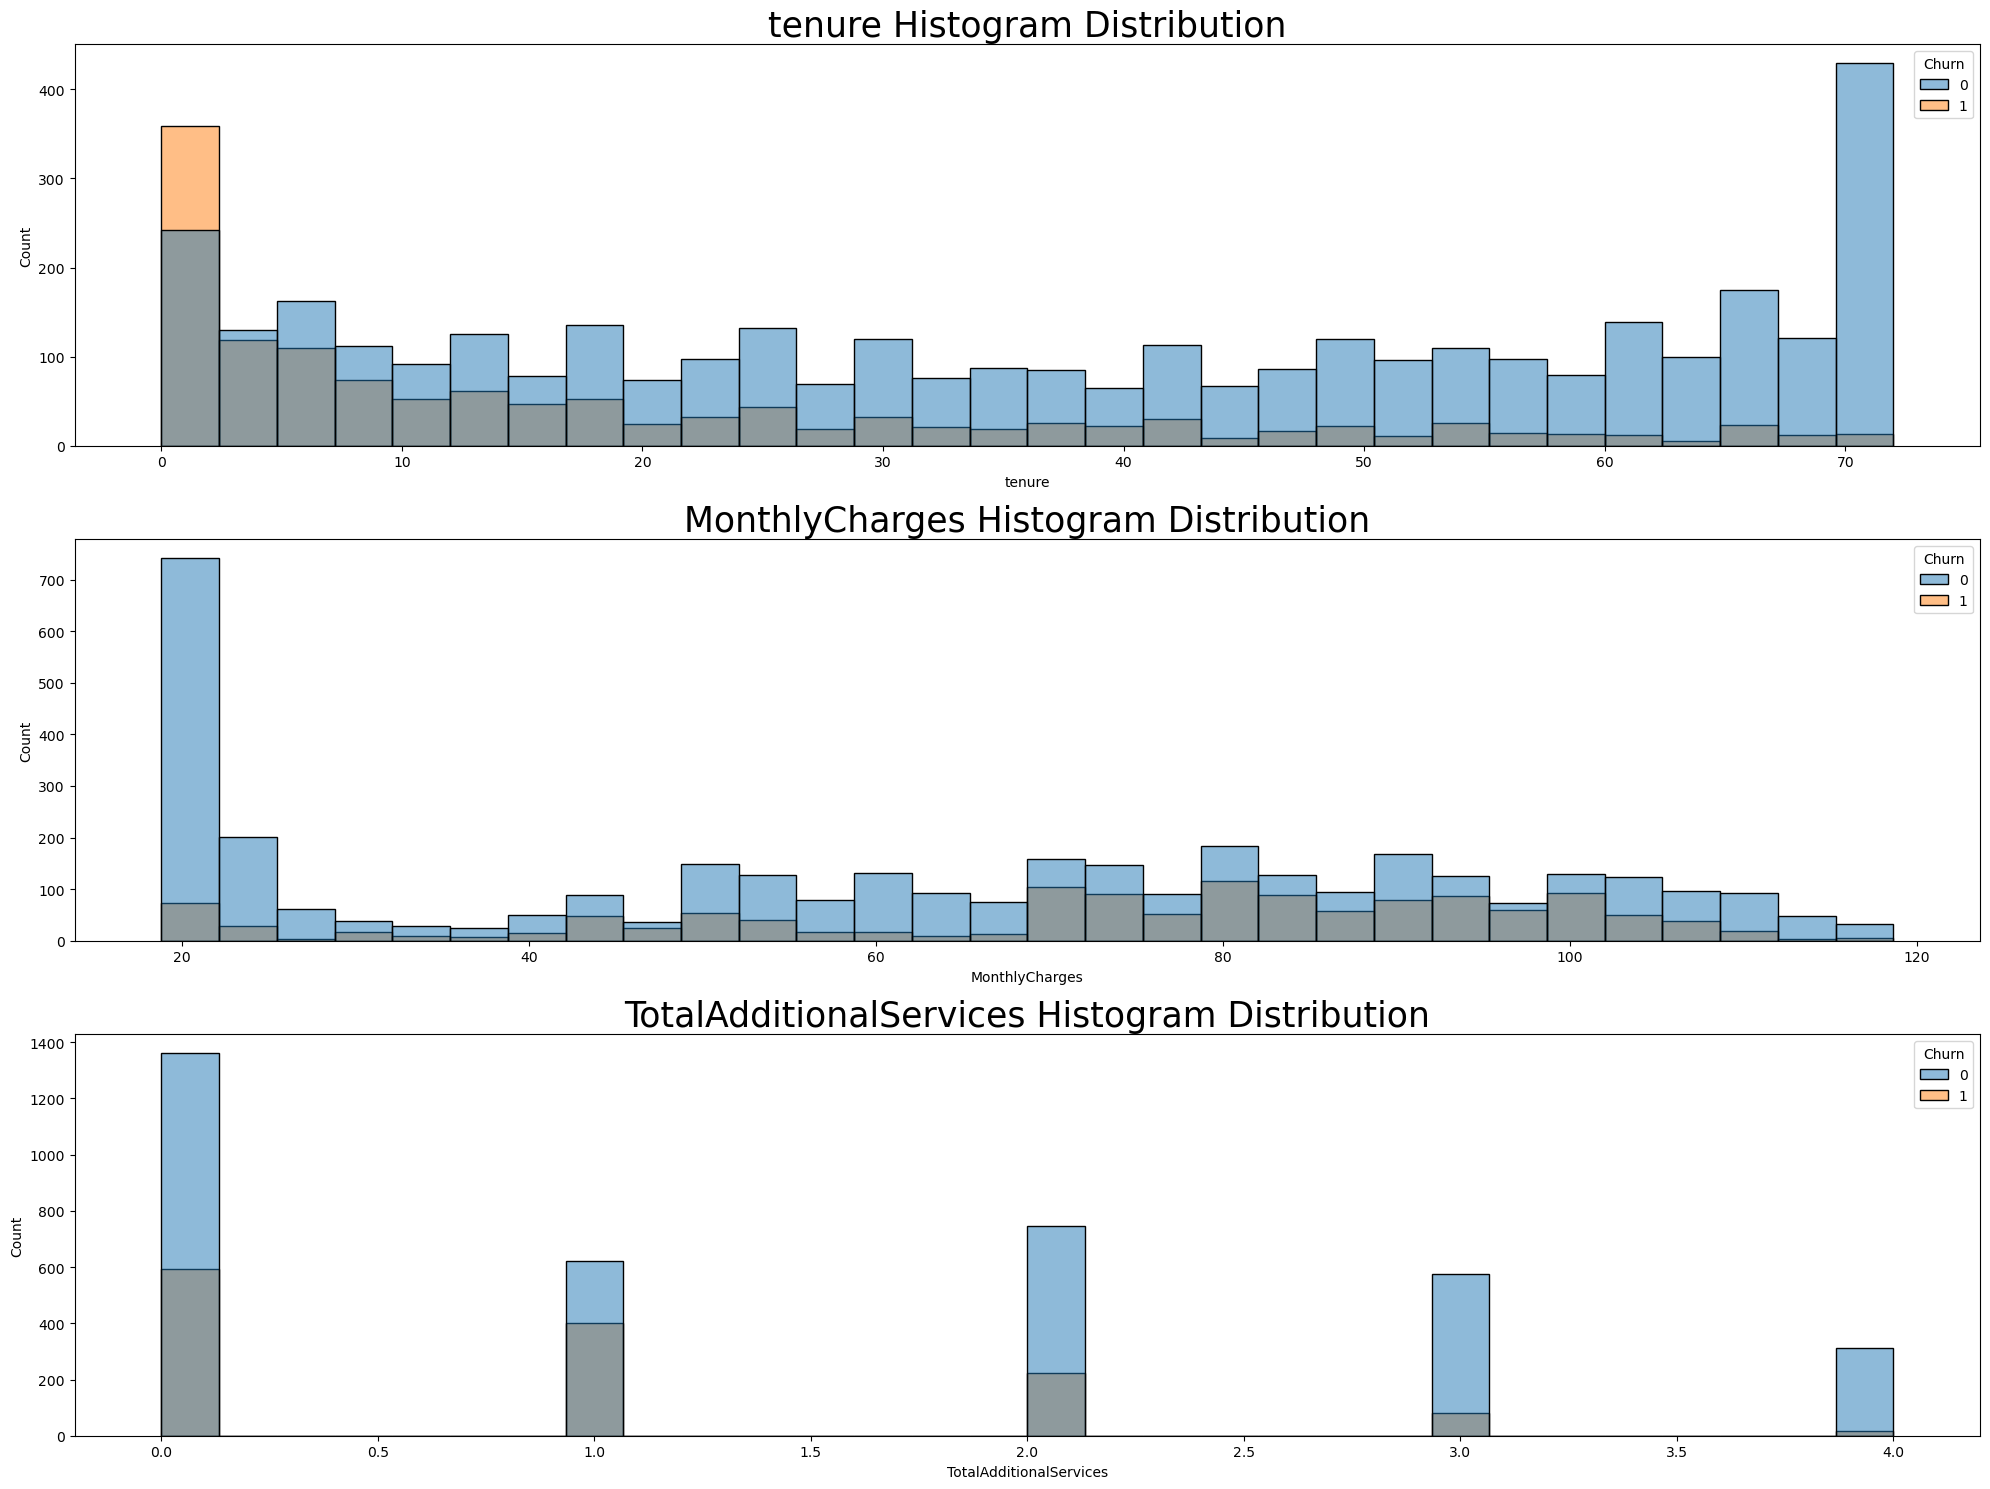

In [16]:
numeric_features = df.drop('Churn', axis=1).select_dtypes(include=['number']).columns

plt.figure(figsize=(20, 15))

for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 1, i + 1)  
    sns.histplot(data=df, x=feature, hue='Churn', bins=30)
    plt.title(f'{feature} Histogram Distribution', fontsize=25)

plt.tight_layout()
plt.show()


> Notes:
> - Customer yang churn cenderung memiliki durasi masa berlangganan yang tidak lama, sementara customer yang tidak churn memiliki distribusi yang lebih merata. Dapat diasumsuikan bahwa durasi seorang customer berlanggan berpengaruh terhadap tingkat kemungkinan churn.
> - Customer yang churn maupun tidak churn cenderung memiliki distribusi tagihan bulanan yang sama, walaupun terdapat perbedaan volume data yang signifikan pada beberapa bin. Dapat terlihat konsentrasi data customer yang churn lebih tinggi pada kelompok tagihan bulanan yang relatif besar.
> - Customer yang churn cenderung lebih sedikit berlanggaan layanan tambahan seperti keamanan device, tech support, dan lain sebagainya. Cenderung mereka hanya berlangganan internet saja.

#### **Categorical Features**

In [17]:
df[df['Churn'] == 1].select_dtypes(exclude='number').describe()

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,TenureCategory,ChargesCategory
count,1316,1316,1316,1316,1316,1316,1316,1316,1316,1316
unique,2,3,3,3,3,3,3,2,4,4
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,Short-Term,High
freq,1091,1022,885,916,851,1020,1178,991,662,469


> Notes:
> - Customer yang churn mayoritas tidak berlangganan service lain kecuali layanan internet dengan kontrak bulanan.
> - Customer yang churn mayoritas membayar tagihan dengan kontrak bulanan.

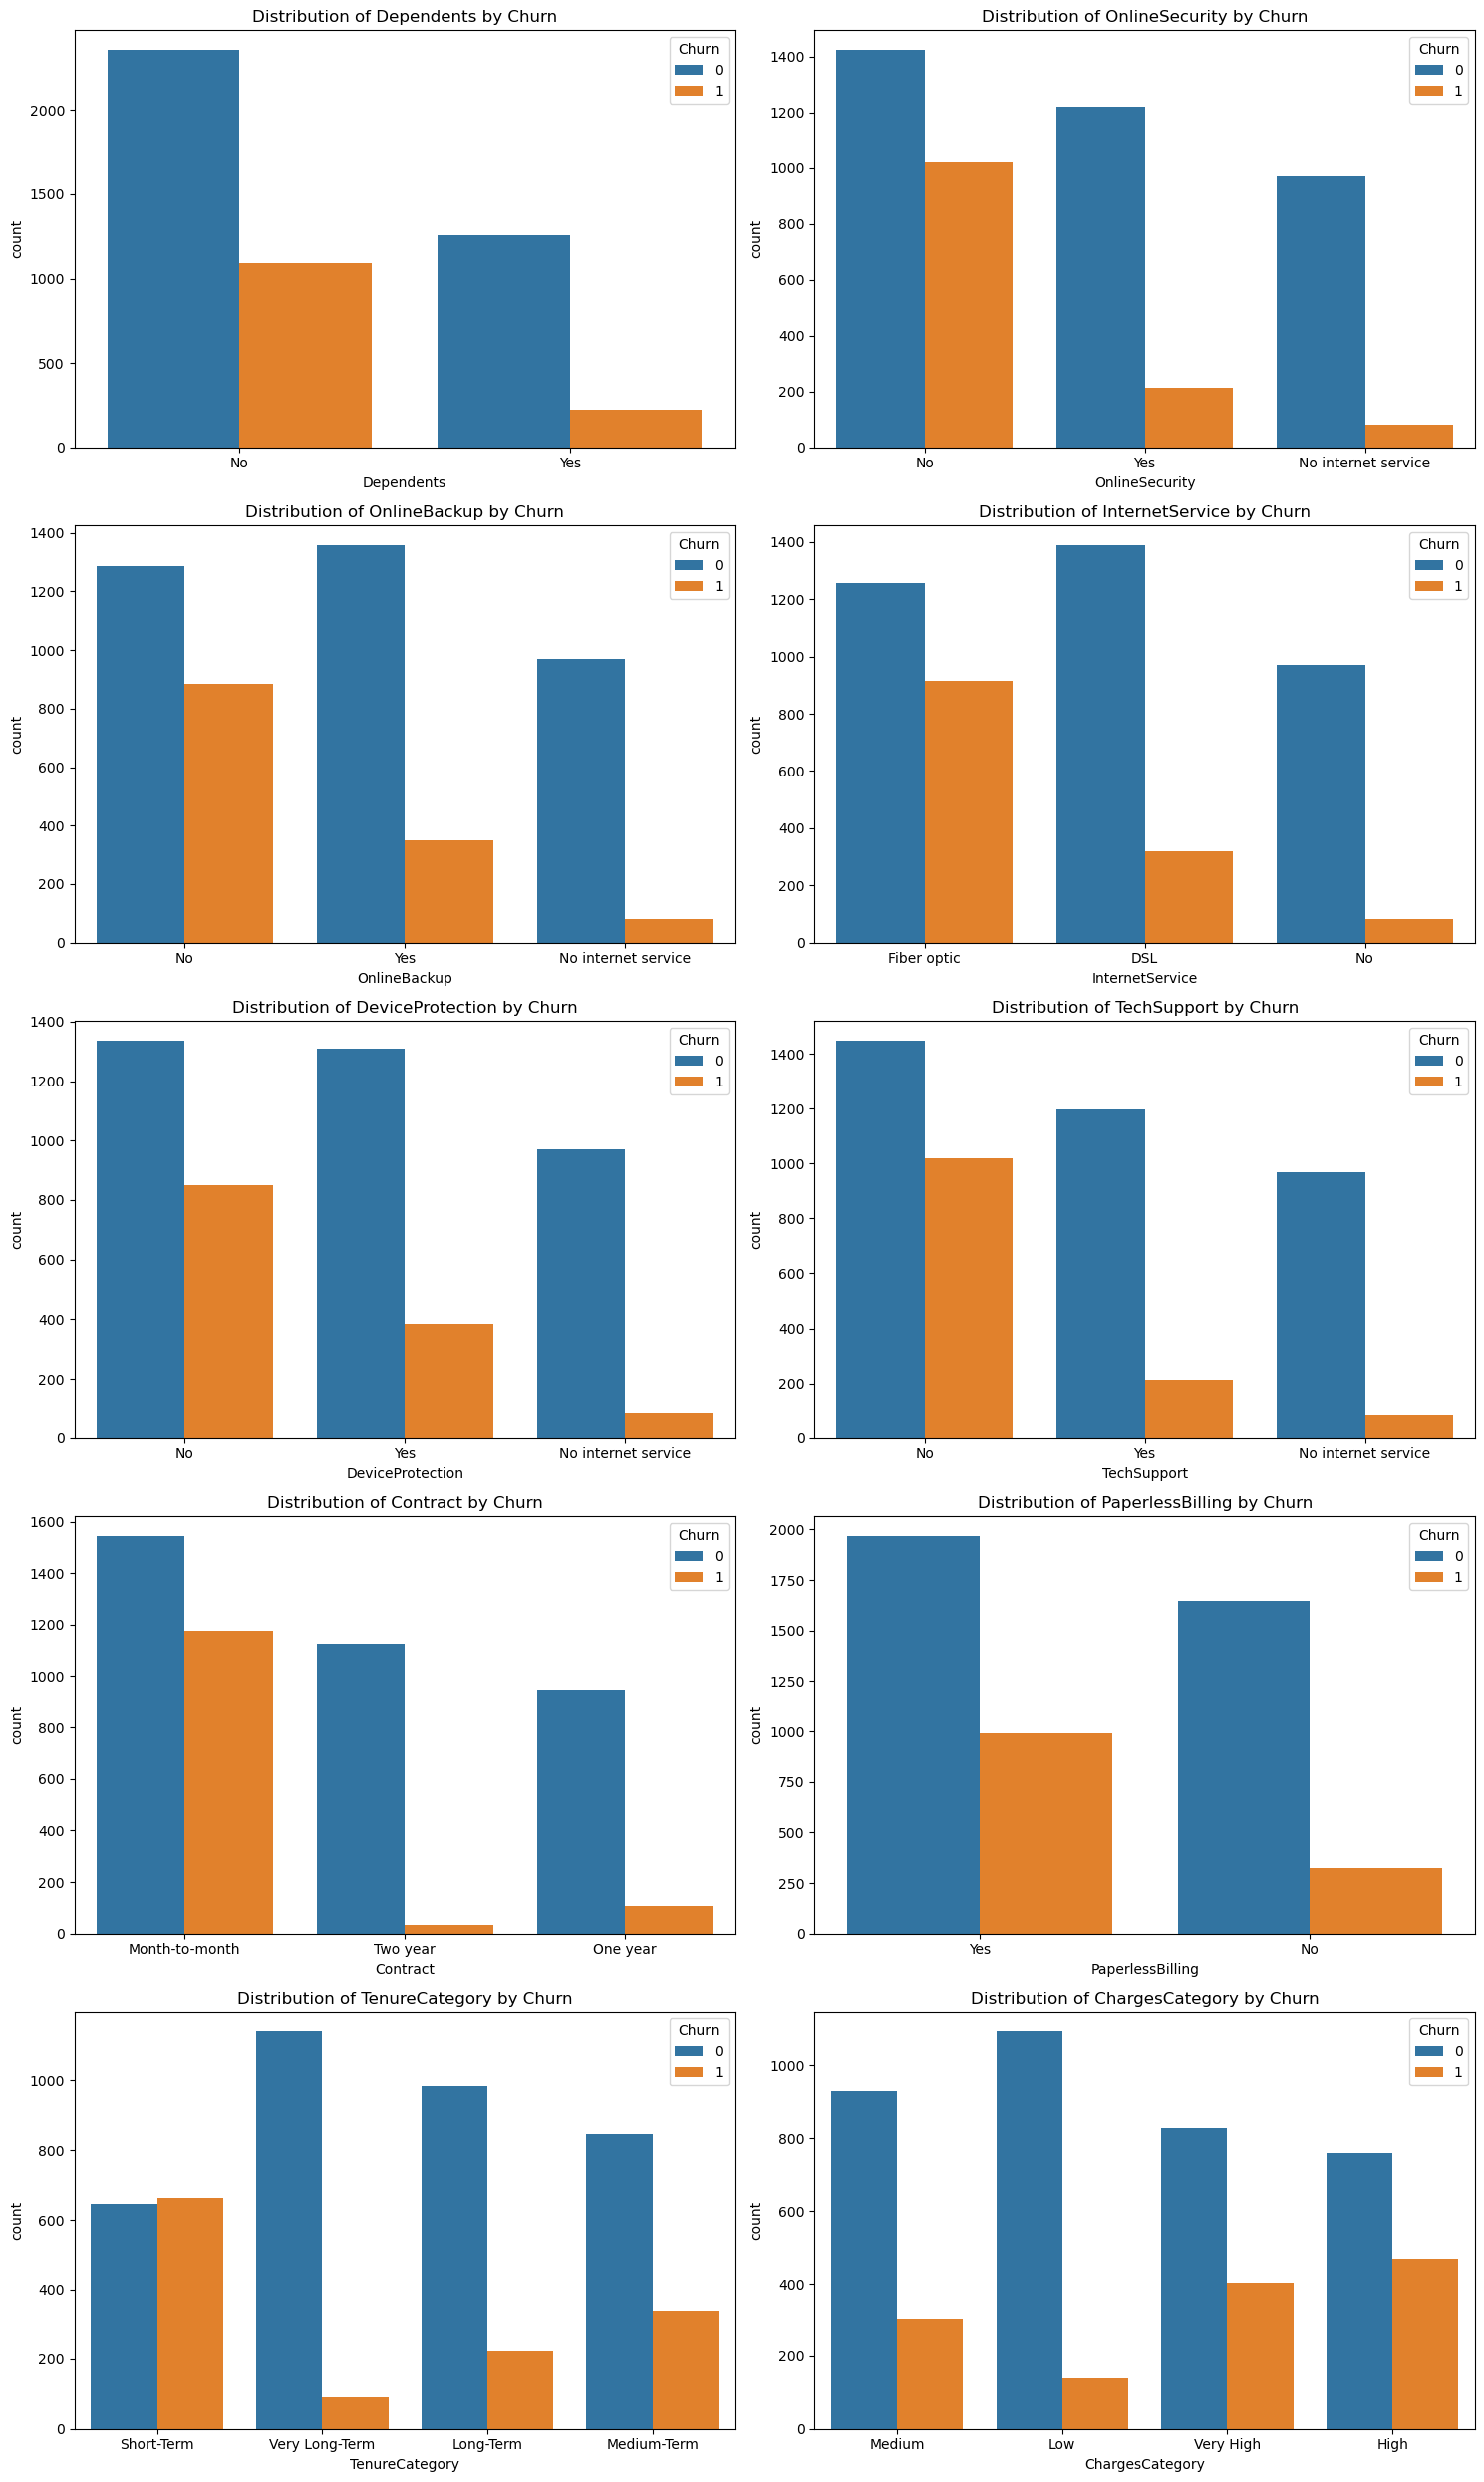

In [18]:
import math

categorical_feat = df.select_dtypes(exclude=['number']).columns

n_cols = 2 
n_rows = math.ceil(len(categorical_feat) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_feat):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Churn')

plt.tight_layout()
plt.show()


> Notes:
> - **`Dependents:`** Customer yang **tidak memiliki tanggungan** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang tidak punya tanggunan.
>
> - **`OnlineSecurity:`** Customer yang **tidak berlangganan keamanan online** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang berlangganan.
>
> - **`OnlineBackup:`** Customer yang **tidak berlangganan backup online** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang berlangganan.
>
> - **`InternetService:`** Customer yang **berlangganan Internet Fiber Optic** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan tipe DSL maupun yang tidak berlangganan.
>
> - **`DeviceProtection:`** Customer yang **tidak berlangganan perlindungan device** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang berlangganan.
>
> - **`TechSupport:`** Customer yang **tidak berlangganan dukungan teknis** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang berlangganan.
>
> - **`Contract:`** Customer yang memiliki **kontrak bulanan** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan tipe kontrak lainnya.
>
> - **`PaperlessBilling:`** Customer yang memilih untuk **tidak menerima tagihan berbentuk kertas** cenderung memiliki tingkat churn yang lebih tinggi dibandingkan dengan yang tidak punya tanggunan.

## **Modeling and Evaluation**

#### **Split Data**

In [19]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2002)

> Notes:
> - Pada langkah ini, data dibagi menjadi set training (80%) dan set testing (20%), dengan variabel target ("Churn") yang telah diubah menjadi hasil biner (1 untuk "Yes" dan 0 untuk "No").

#### **Preprocessing**

In [20]:
categorical_nominal = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']
categorical_ordinal = ['ChargesCategory', 'TenureCategory']
numerical_columns = ['MonthlyCharges', 'tenure', 'TotalAdditionalServices']

# scaler and encoder
scaler = MinMaxScaler()
one_hot_encoder = OneHotEncoder()
ordinal_encoder = OrdinalEncoder(categories=[
    ['Low', 'Medium', 'High', 'Very High'],      
    ['Short-Term', 'Medium-Term', 'Long-Term', 'Very Long-Term']
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_columns),                      
        ('cat_nom', one_hot_encoder, categorical_nominal),      
        ('cat_ord', ordinal_encoder, categorical_ordinal)
    ])

> Notes:
>
> - Pada langkah ini, fitur numerik seperti **MonthlyCharges**, **tenure**, dan **TotalAdditionalServices** telah dinormalisasi menggunakan **MinMax Scaler**. Hal ini dilakukan karena distribusi fitur tidak normal dan tidak ada outliers yang signifikan. Scaling juga dapat membantu model yang bersifat *distance-based* seperti KNN untuk menjadi lebih akurat karena range values yang konsisten.
>
> - Fitur kategorikal nominal seperti **Dependents**, **InternetService**, **OnlineSecurity**, dan lainnya di-encode menggunakan **One-Hot Encoding** karena tidak terdapat hirarki pada values dan kardinalitas juga cukup rendah. 
>
> - Fitur kategorikal ordinal seperti **ChargesCategory** dan **TenureCategory** telah di-encode menggunakan **Ordinal Encoding**, yang mempertahankan urutan atau ranking antar kategori untuk membantu model mengenali hubungan linier atau non-linier yang terkait dengan fitur tersebut.


In [21]:
def get_feature_names(preprocessor, numerical_columns, categorical_nominal, categorical_ordinal):
    output_features = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num': 
            output_features.extend(numerical_columns)
        
        elif name == 'cat_nom':
            categories = transformer.categories_
            for col, cats in zip(categorical_nominal, categories):
                output_features.extend([f"{col}_{cat}" for cat in cats])
        
        elif name == 'cat_ord':
            output_features.extend(categorical_ordinal)
    
    return output_features

In [22]:
# preprocessed training data
X_train_transformed = preprocessor.fit_transform(X_train)

feature_names = get_feature_names(preprocessor, numerical_columns, categorical_nominal, categorical_ordinal)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

X_train_transformed_df.sample(5)

,MonthlyCharges,tenure,TotalAdditionalServices,Dependents_No,Dependents_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,...,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,ChargesCategory,TenureCategory
2673,0.016024,0.083333,0.00,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
996,0.674011,0.444444,0.25,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0
535,0.329494,0.819444,0.25,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
2156,0.011517,0.041667,0.00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3734,0.502253,0.069444,0.00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


> Notes:
>
> - Setelah melakukan preprocessing, bentuk data berubah dan bertambah 15 kolom baru menjadi **27 fitur**.


#### **Training Model (Base) - Train Data**

In [23]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

results_mean = {}
results_std = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='recall')
    results_mean[model_name] = scores.mean()
    results_std[model_name] = scores.std()

results_df = pd.DataFrame({
    'Model': results_mean.keys(),
    'Recall': results_mean.values(),
    'Std Dev': results_std.values()
})

results_df = results_df.sort_values(by='Recall', ascending=False)

results_df

[LightGBM] [Info] Number of positive: 843, number of negative: 2312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 3155, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267195 -> initscore=-1.008901
[LightGBM] [Info] Start training from score -1.008901
[LightGBM] [Info] Number of positive: 842, number of negative: 2313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 3155, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266878 -> initscore=-1.010521
[LightGBM] [

,Model,Recall,Std Dev
6,Naive Bayes,0.837621,0.016388
7,AdaBoost,0.537459,0.025306
0,Logistic Regression,0.527998,0.015377
8,XGBoost,0.520388,0.016744
1,Decision Tree,0.515631,0.035873
9,CatBoost,0.513740,0.017966
3,LightGBM,0.508978,0.029327
5,K-Nearest Neighbors,0.493776,0.024465
2,Random Forest,0.484288,0.037858
4,Support Vector Machine,0.475757,0.026098


> Notes:
>
> - Setelah melakukan pelatihan menggunakan 5-fold cross-validation, model **Naive Bayes** memiliki performa terbaik dengan recall mean 0.8376 dan standar deviasi 0.0164.
>
> - Model **AdaBoost** dan **Logistic Regression** mengikuti dengan recall masing-masing 0.5375 dan 0.5280, namun dengan variansi yang lebih rendah.
>
> - Perlu diperhatikan bahwa performa ini dihasilkan dari pengujian ke **data train**.

#### **Training Model (Base) - Test Data**

In [24]:
test_results = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    
    test_results[model_name] = {
        'Recall': recall
    }

test_results_df = pd.DataFrame.from_dict(test_results, orient='index')

test_results_df = test_results_df.reset_index()
test_results_df = test_results_df.rename(columns={'index': 'Model'})

test_results_df = test_results_df.sort_values(by='Recall', ascending=False)

test_results_df

[LightGBM] [Info] Number of positive: 1053, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266988 -> initscore=-1.009959
[LightGBM] [Info] Start training from score -1.009959


,Model,Recall
6,Naive Bayes,0.802281
2,Random Forest,0.555133
7,AdaBoost,0.539924
0,Logistic Regression,0.524715
1,Decision Tree,0.520913
9,CatBoost,0.509506
8,XGBoost,0.501901
5,K-Nearest Neighbors,0.498099
3,LightGBM,0.482890
4,Support Vector Machine,0.460076


> Notes:
>
> - Pada pengujian ini, dilakukan evaluasi model menggunakan **test data** setelah pelatihan pada **train data**, dengan menggunakan pipeline untuk menggabungkan preprocessing dan model pelatihan. Hal ini memastikan preprocessing diterapkan secara konsisten pada data test tanpa risiko data leakage.
>
> - **Model Naive Bayes** tetap menunjukkan performa terbaik dengan **recall 0.8023** pada test data, menegaskan posisinya sebagai model dasar terbaik untuk mendeteksi churn.
>
> - **Random Forest** mengalami peningkatan yang signifikan, naik ke posisi kedua dengan **recall 0.5589**, sementara **AdaBoost** juga mempertahankan performa yang stabil dengan **recall 0.5399**.
>
> - **Logistic Regression** dan **Decision Tree** menunjukkan hasil yang serupa, masing-masing dengan **recall 0.5247**.
>
> - Beberapa model seperti **Support Vector Machine** dan **LightGBM** masih memiliki performa yang lebih rendah, dengan **recall** di bawah **0.50**.

#### **Training Model (Base) - Evaluation**

In [25]:
new_result_df = results_df.set_index('Model')
new_test_result_df = test_results_df.set_index('Model')

combined_results_df = pd.concat([new_result_df, new_test_result_df], axis=1)

combined_results_df.columns = ['Recall - Train', 'Std Dev - Train', 
                               'Recall - Test']

combined_results_df

,Recall - Train,Std Dev - Train,Recall - Test
Model,,,
Naive Bayes,0.837621,0.016388,0.802281
AdaBoost,0.537459,0.025306,0.539924
Logistic Regression,0.527998,0.015377,0.524715
XGBoost,0.520388,0.016744,0.501901
Decision Tree,0.515631,0.035873,0.520913
CatBoost,0.513740,0.017966,0.509506
LightGBM,0.508978,0.029327,0.482890
K-Nearest Neighbors,0.493776,0.024465,0.498099
Random Forest,0.484288,0.037858,0.555133


> Notes:
>
> - Dari evaluasi model dengan train dan test data, Naive Bayes menunjukkan performa terbaik dengan recall **0.8376** di training dan **0.8023** di test data.
>
> - Walaupun ada sedikit penurunan performa di test data, **Naive Bayes** tetap unggul dibanding model lain.
>
> - Model lain seperti **AdaBoost** dan **Logistic Regression** memiliki recall lebih rendah, dengan penurunan yang tidak signifikan di test data (Adaboost mengalami peningkatan performa pada data test yang kemungkinan terjadi karena jumlah label churn lebih banyak dibandingkan pada data train saat splitting).
>
> - Naive Bayes menjadi **model dasar terbaik** untuk deteksi customer churn pada tahap ini.

#### **Training Model (Feature Selection vs No Feature Selection)**

In [26]:
test_results_fs = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),                
        ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  
        ('classifier', model)                         
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    
    test_results_fs[model_name] = {
        'Recall - Train': recall_train,
        'Recall - Test': recall_test
    }

test_results_fs_df = pd.DataFrame.from_dict(test_results_fs, orient='index')

test_results_fs_df = test_results_fs_df.reset_index()
test_results_fs_df = test_results_fs_df.rename(columns={'index': 'Model'})

test_results_fs_df = test_results_fs_df.sort_values(by='Recall - Test', ascending=False)

test_results_fs_df

[LightGBM] [Info] Number of positive: 1053, number of negative: 2891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266988 -> initscore=-1.009959
[LightGBM] [Info] Start training from score -1.009959


,Model,Recall - Train,Recall - Test
6,Naive Bayes,0.848053,0.821293
2,Random Forest,0.983856,0.555133
1,Decision Tree,0.974359,0.536122
5,K-Nearest Neighbors,0.618234,0.528517
8,XGBoost,0.783476,0.524715
0,Logistic Regression,0.535613,0.520913
7,AdaBoost,0.554606,0.517110
3,LightGBM,0.681861,0.498099
9,CatBoost,0.620133,0.486692
4,Support Vector Machine,0.460589,0.460076


In [27]:
combined_feature_selection_df = pd.concat([combined_results_df.drop('Std Dev - Train', axis=1).reset_index().set_index('Model'), 
                                           test_results_fs_df.set_index('Model')], 
                                          axis=1, 
                                          keys=['Without Feature Selection', 'With Feature Selection'])

combined_feature_selection_df.columns = ['Recall - No FS (Train)', 'Recall - No FS (Test)', 
                                         'Recall - FS (Train)', 'Recall - FS (Test)']

combined_feature_selection_df

,Recall - No FS (Train),Recall - No FS (Test),Recall - FS (Train),Recall - FS (Test)
Model,,,,
Naive Bayes,0.837621,0.802281,0.848053,0.821293
AdaBoost,0.537459,0.539924,0.554606,0.517110
Logistic Regression,0.527998,0.524715,0.535613,0.520913
XGBoost,0.520388,0.501901,0.783476,0.524715
Decision Tree,0.515631,0.520913,0.974359,0.536122
CatBoost,0.513740,0.509506,0.620133,0.486692
LightGBM,0.508978,0.482890,0.681861,0.498099
K-Nearest Neighbors,0.493776,0.498099,0.618234,0.528517
Random Forest,0.484288,0.555133,0.983856,0.555133


> Notes:
>
> - Pada evaluasi ini, digunakan teknik **feature selection** menggunakan **SelectKBest** dengan memilih 20 fitur terbaik untuk membandingkan performa model dengan dan tanpa feature selection.
>
> - SelectKBest **menghitung skor setiap fitur berdasarkan metode statistik** (secara default ANOVA F-test yang menghitung variabilitas fitur) dan memilih k fitur dengan skor tertinggi. Ini membantu mengurangi dimensi data, sehingga model dapat berfokus pada fitur yang paling berpengaruh terhadap prediksi.
>
> - **SelectKBest** membantu beberapa model dalam meningkatkan performa. Misalnya, **Naive Bayes** mengalami peningkatan recall dari **0.8023** menjadi **0.8213**, menunjukkan bahwa pemilihan fitur yang lebih relevan dapat membantu model lebih fokus pada informasi penting.
>
> - Secara keseluruhan, **SelectKBest** membantu sebagian besar model untuk meningkatkan recall, terutama dengan model seperti **XGBoost** dan **K-Nearest Neighbors**, yang menunjukkan peningkatan signifikan. Feature selection bisa menjadi alat yang efektif dalam membantu model berfokus pada fitur yang lebih relevan.

#### **Training Model (Sampling vs No Sampling)**

In [28]:
smote = SMOTE(random_state=2002)

test_results_sampling_fs = {}

for model_name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),                
        ('feature_selection', SelectKBest(score_func=f_classif, k=20)), 
        ('smote', smote),      # SMOTE oversampling step
        ('classifier', model)                        
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    
    test_results_sampling_fs[model_name] = {
        'Recall - Train': recall_train,
        'Recall - Test': recall_test
    }

test_results_sampling_fs_df = pd.DataFrame.from_dict(test_results_sampling_fs, orient='index')

test_results_sampling_fs_df = test_results_sampling_fs_df.reset_index()
test_results_sampling_fs_df = test_results_sampling_fs_df.rename(columns={'index': 'Model'})

test_results_sampling_fs_df = test_results_sampling_fs_df.sort_values(by='Recall - Test', ascending=False)

test_results_sampling_fs_df

[LightGBM] [Info] Number of positive: 2891, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,Recall - Train,Recall - Test
6,Naive Bayes,0.848053,0.821293
7,AdaBoost,0.797721,0.809886
0,Logistic Regression,0.788224,0.783270
4,Support Vector Machine,0.811016,0.779468
5,K-Nearest Neighbors,0.864198,0.749049
9,CatBoost,0.793922,0.688213
3,LightGBM,0.838557,0.684411
8,XGBoost,0.883191,0.653992
2,Random Forest,0.989554,0.615970
1,Decision Tree,0.976258,0.536122


In [29]:
test_results_fs_df = test_results_fs_df.rename(columns={'Recall': 'Recall - FS'})

test_results_sampling_fs_df = test_results_sampling_fs_df.rename(columns={'Recall': 'Recall - SMOTE + FS'})

# Combine the results
combined_sampling_fs_df = pd.concat([
    combined_results_df.drop('Std Dev - Train', axis=1).reset_index().set_index('Model'),                
    test_results_fs_df.set_index('Model'),   
    test_results_sampling_fs_df.set_index('Model')   
], axis=1)

combined_sampling_fs_df.columns = ['Recall - Base (Train)', 'Recall - Base (Test)', 
                                         'Recall - FS (Train)', 'Recall - FS (Test)', 
                                         'Recall - FS + SMOTE (Train)', 'Recall - FS (Test) + SMOTE']

combined_sampling_fs_df

,Recall - Base (Train),Recall - Base (Test),Recall - FS (Train),Recall - FS (Test),Recall - FS + SMOTE (Train),Recall - FS (Test) + SMOTE
Model,,,,,,
Naive Bayes,0.837621,0.802281,0.848053,0.821293,0.848053,0.821293
AdaBoost,0.537459,0.539924,0.554606,0.517110,0.797721,0.809886
Logistic Regression,0.527998,0.524715,0.535613,0.520913,0.788224,0.783270
XGBoost,0.520388,0.501901,0.783476,0.524715,0.883191,0.653992
Decision Tree,0.515631,0.520913,0.974359,0.536122,0.976258,0.536122
CatBoost,0.513740,0.509506,0.620133,0.486692,0.793922,0.688213
LightGBM,0.508978,0.482890,0.681861,0.498099,0.838557,0.684411
K-Nearest Neighbors,0.493776,0.498099,0.618234,0.528517,0.864198,0.749049
Random Forest,0.484288,0.555133,0.983856,0.555133,0.989554,0.615970


> Notes:
>
> - **SMOTE + Feature Selection** secara signifikan meningkatkan performa model seperti **AdaBoost** (dari **0.5171** menjadi **0.8099**) dan **Logistic Regression** (dari **0.5209** menjadi **0.7833**). Ini kemungkinan terjadi karena oversampling menyeimbangkan distribusi kelas, membantu model lebih baik dalam mendeteksi churn.
>
> - SMOTE (Synthetic Minority Over-sampling Technique) bekerja dengan **membuat sampel sintetik dari kelas minoritas** dengan memilih titik acak dalam fitur dan menghasilkan titik baru berdasarkan jarak ke titik-titik terdekat. Dalam hal ini "titik" adalah data points.
>
> - Secara keseluruhan, **SMOTE** meningkatkan recall pada model yang kesulitan dengan dataset tidak seimbang, terutama pada **K-Nearest Neighbors** dan **Support Vector Machine**, dengan menyediakan lebih banyak sampel sintetik dari kelas minoritas.
>
> - **Naive Bayes** tetap menjadi model dengan performa terbaik dengan cara kerja seperti berikut:
>
>    Model ini merupakan model probabilistik yang mengklasifikasikan data dengan **menghitung probabilitas/kemungkinan setiap kelas berdasarkan setiap fitur** (diasumsikan oleh model bahwa setiap fitur itu independen). **Kinerjanya baik pada dataset yang tidak seimbang** karena dapat secara efektif **memperkirakan probabilitas untuk kelas minoritas**, memungkinkan deteksi churn yang akurat meskipun terdapat lebih sedikit contoh.

#### **Training Model - Classification Report**

In [30]:
classification_reports = {}

# 1. Base Model (No Feature Selection, No Sampling) - Naive Bayes Only
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models['Naive Bayes'])
])

pipeline.fit(X_train, y_train)

y_test_pred_base = pipeline.predict(X_test)

classification_reports['Naive Bayes - Base'] = classification_report(y_test, y_test_pred_base)

# 2. Feature Selection (FS) without Sampling - Naive Bayes Only
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)), 
    ('classifier', models['Naive Bayes'])
])

pipeline.fit(X_train, y_train)

y_test_pred_fs = pipeline.predict(X_test)

classification_reports['Naive Bayes - FS'] = classification_report(y_test, y_test_pred_fs)

# 3. Feature Selection + SMOTE - Naive Bayes Only
smote = SMOTE(random_state=2002)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  
    ('smote', smote),
    ('classifier', models['Naive Bayes'])
])

pipeline.fit(X_train, y_train)

y_test_pred_fs_smote = pipeline.predict(X_test)

classification_reports['Naive Bayes - FS + SMOTE'] = classification_report(y_test, y_test_pred_fs_smote)

for model_scenario, report in classification_reports.items():
    print(f"Classification Report for {model_scenario}:\n")
    print(report)
    print("\n" + "="*80 + "\n")


Classification Report for Naive Bayes - Base:

              precision    recall  f1-score   support

           0       0.90      0.68      0.77       723
           1       0.47      0.80      0.60       263

    accuracy                           0.71       986
   macro avg       0.69      0.74      0.68       986
weighted avg       0.79      0.71      0.73       986



Classification Report for Naive Bayes - FS:

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       723
           1       0.46      0.82      0.59       263

    accuracy                           0.69       986
   macro avg       0.68      0.73      0.67       986
weighted avg       0.79      0.69      0.71       986



Classification Report for Naive Bayes - FS + SMOTE:

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       723
           1       0.46      0.82      0.59       263

    accuracy                     

> Notes:
>
> - Dengan menggunakan **SMOTE + Feature Selection**, model mendapatkan peningkatan performa sebanyak **2% pada recall** customer churn walaupun mengalami pengurangan **presisi sebanyak 1%**.
>
> - Hal ini sesuai dengan tujuan kita yang memfokuskan target terhadap metriks recall atau meminimalisir FN (False Negative).

#### **Hyperparameter Tuning**

In [31]:
param_grids = {
    'AdaBoost': {
        'feature_selection__k': [15, 20, 25],
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3]
    },
    'Naive Bayes': {},  # No parameters to tune for Naive Bayes
    'K-Nearest Neighbors': {
        'feature_selection__k': [15, 20, 25],
        'classifier__n_neighbors': [5, 7, 9, 11, 15],
        'classifier__weights': ['uniform', 'distance', 'balanced']
    },
    'Support Vector Machine': {
        'feature_selection__k': [15, 20, 25],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': ['balanced']
    },
    'Logistic Regression': {
        'feature_selection__k': [15, 20, 25],
        'classifier__C': [0.01, 0.1, 1.0, 10],
        'classifier__penalty': ['l2']
    }
}

models = {
    'AdaBoost': AdaBoostClassifier(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression()
}

> Notes:
>
> - Berdasarkan hasil pada tahapan sebelumnya, dapat dikatakan bahwa 5 model terbaik yang akan dilakukan tuning adalah **Naive Bayes**, **AdaBoost**, **SVM**, **KNN**, dan **Logistic Regression**.
>
> - Feature selection menggunakan **SelectKBest** juga akan dilakukan tuning untuk mendapatkan jumlah fitur terbaik.

In [32]:
from sklearn import set_config

best_models = {}
for model_name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),                
        ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  
        ('smote', smote),                              
        ('classifier', model)                       
    ])
    
    if param_grids[model_name]:  
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],  
            scoring='recall',                   
            cv=5,                              
            n_jobs=-1                           
        )
        
        grid_search.fit(X_train, y_train)
        
        best_models[model_name] = grid_search.best_estimator_

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        
    else:
        # For Naive Bayes, which has no parameters to tune.
        pipeline.fit(X_train, y_train)
        best_models[model_name] = pipeline

set_config(display='diagram')

for model_name, best_model in best_models.items():
    display(best_model)
    
    y_test_pred = best_model.predict(X_test)
    print(f"Classification report for {model_name} after tuning:\n")
    print(classification_report(y_test, y_test_pred))
    print("="*80)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Best parameters for AdaBoost: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50, 'feature_selection__k': 15}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 15, 'classifier__weights': 'uniform', 'feature_selection__k': 15}
Best parameters for Support Vector Machine: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'feature_selection__k': 15}
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'feature_selection__k': 15}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalAdditionalServices']),
                                                 ('cat_nom', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Very '
                                                                              'High'],
                                                                             ['Short-Term',
                                                                              'Medium-Term',
                                                                              'Long-Term',
                                                                              'Very '
                                                                              'Long-Term']]),
                                                  ['ChargesCategory',
                                                   'TenureCategory'])])),
                ('feature_selection', SelectKBest(k=15)),
                ('smote', SMOTE(random_state=2002)),
                ('classifier', AdaBoostClassifier(learning_rate=0.01))])

Classification report for AdaBoost after tuning:

              precision    recall  f1-score   support

           0       0.93      0.56      0.70       723
           1       0.42      0.88      0.57       263

    accuracy                           0.65       986
   macro avg       0.67      0.72      0.63       986
weighted avg       0.79      0.65      0.66       986



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalAdditionalServices']),
                                                 ('cat_nom', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Very '
                                                                              'High'],
                                                                             ['Short-Term',
                                                                              'Medium-Term',
                                                                              'Long-Term',
                                                                              'Very '
                                                                              'Long-Term']]),
                                                  ['ChargesCategory',
                                                   'TenureCategory'])])),
                ('feature_selection', SelectKBest(k=20)),
                ('smote', SMOTE(random_state=2002)),
                ('classifier', GaussianNB())])

Classification report for Naive Bayes after tuning:

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       723
           1       0.46      0.82      0.59       263

    accuracy                           0.69       986
   macro avg       0.68      0.73      0.67       986
weighted avg       0.79      0.69      0.71       986



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalAdditionalServices']),
                                                 ('cat_nom', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Very '
                                                                              'High'],
                                                                             ['Short-Term',
                                                                              'Medium-Term',
                                                                              'Long-Term',
                                                                              'Very '
                                                                              'Long-Term']]),
                                                  ['ChargesCategory',
                                                   'TenureCategory'])])),
                ('feature_selection', SelectKBest(k=15)),
                ('smote', SMOTE(random_state=2002)),
                ('classifier', KNeighborsClassifier(n_neighbors=15))])

Classification report for K-Nearest Neighbors after tuning:

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       723
           1       0.50      0.73      0.59       263

    accuracy                           0.73       986
   macro avg       0.69      0.73      0.70       986
weighted avg       0.78      0.73      0.75       986



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalAdditionalServices']),
                                                 ('cat_nom', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Very '
                                                                              'High'],
                                                                             ['Short-Term',
                                                                              'Medium-Term',
                                                                              'Long-Term',
                                                                              'Very '
                                                                              'Long-Term']]),
                                                  ['ChargesCategory',
                                                   'TenureCategory'])])),
                ('feature_selection', SelectKBest(k=15)),
                ('smote', SMOTE(random_state=2002)),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', kernel='linear'))])

Classification report for Support Vector Machine after tuning:

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       723
           1       0.46      0.82      0.59       263

    accuracy                           0.69       986
   macro avg       0.68      0.73      0.67       986
weighted avg       0.79      0.69      0.71       986



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalAdditionalServices']),
                                                 ('cat_nom', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High',
                                                                              'Very '
                                                                              'High'],
                                                                             ['Short-Term',
                                                                              'Medium-Term',
                                                                              'Long-Term',
                                                                              'Very '
                                                                              'Long-Term']]),
                                                  ['ChargesCategory',
                                                   'TenureCategory'])])),
                ('feature_selection', SelectKBest(k=15)),
                ('smote', SMOTE(random_state=2002)),
                ('classifier', LogisticRegression(C=0.1))])

Classification report for Logistic Regression after tuning:

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       723
           1       0.51      0.77      0.61       263

    accuracy                           0.74       986
   macro avg       0.70      0.75      0.71       986
weighted avg       0.79      0.74      0.75       986



> Notes:
>
> - Proses **tuning hyperparameter** dengan kombinasi **SMOTE dan Feature Selection** berhasil meningkatkan **recall** pada beberapa model, menunjukkan efektivitas dalam mengidentifikasi pelanggan yang berpotensi churn.
>
> - **AdaBoost** menunjukkan hasil terbaik dengan recall **88%**, meskipun presisi relatif rendah (**42%**). Ini menjadikannya pilihan utama untuk meminimalisir false negatives.
>
> - Model **Logistic Regression** juga menunjukkan kinerja yang baik dengan recall **77%** dan presisi **51%**, menawarkan keseimbangan yang baik antara keduanya.

#### **Voting Model**

In [33]:
from sklearn.ensemble import VotingClassifier

ada_boost = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')
svm = SVC(C=0.1, class_weight='balanced', gamma='scale', kernel='linear', probability=True)
log_reg = LogisticRegression(C=0.1, penalty='l2')
naive_bayes = GaussianNB()

voting_clf = VotingClassifier(
    estimators=[
        ('ada_boost', ada_boost),
        ('knn', knn),
        ('svm', svm),
        ('log_reg', log_reg),
        ('naive_bayes', naive_bayes)
    ],
    voting='soft' 
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),                
    ('smote', smote),
    ('feature_selection', SelectKBest(k=15)),
    ('voting_classifier', voting_clf)
])

pipeline.fit(X_train, y_train)

y_probs = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

print(f'Voting Classifier Recall: {recall:.2f}')
print(classification_report(y_test, y_pred))

Voting Classifier Recall: 0.51
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       723
           1       0.46      0.82      0.59       263

    accuracy                           0.70       986
   macro avg       0.68      0.74      0.67       986
weighted avg       0.79      0.70      0.71       986



> Notes:
>
> - Model **Voting Classifier** yang menggabungkan **AdaBoost, K-Nearest Neighbors, SVC, Logistic Regression**, dan **Naive Bayes** mencapai **recall sebesar 82%**, menunjukkan kemampuan yang baik dalam mengidentifikasi pelanggan yang berpotensi churn.
>
> - Dengan **voting soft**, model mampu memanfaatkan probabilitas prediksi dari setiap classifier, meningkatkan kinerja secara keseluruhan meskipun presisi untuk kelas churn (1) tetap rendah di **46%**.
>
> - Keseimbangan antara **recall** yang tinggi dan **presisi** yang lebih rendah mengindikasikan trade-off yang konsisten, memperkuat fokus pada upaya retensi pelanggan daripada akuisisi.

#### **Business Evaluation - Confusion Matrix**

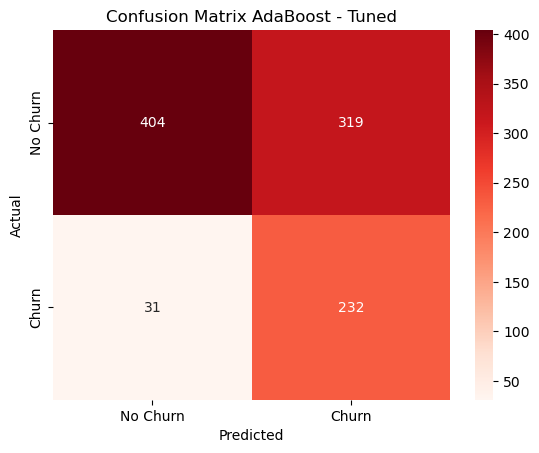

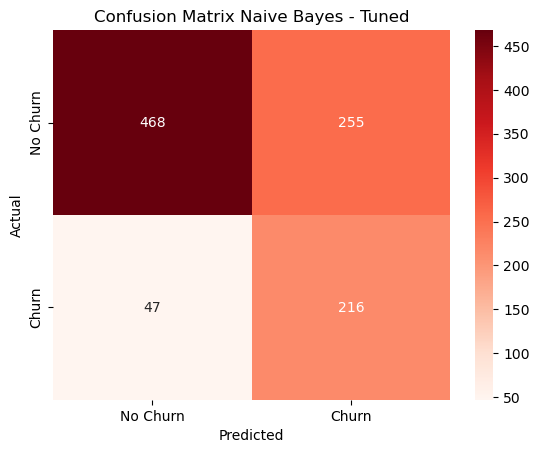

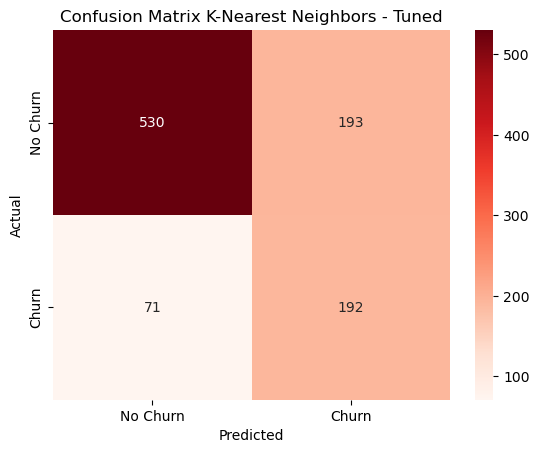

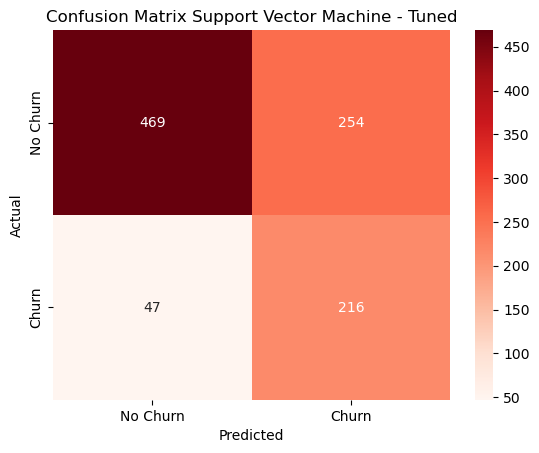

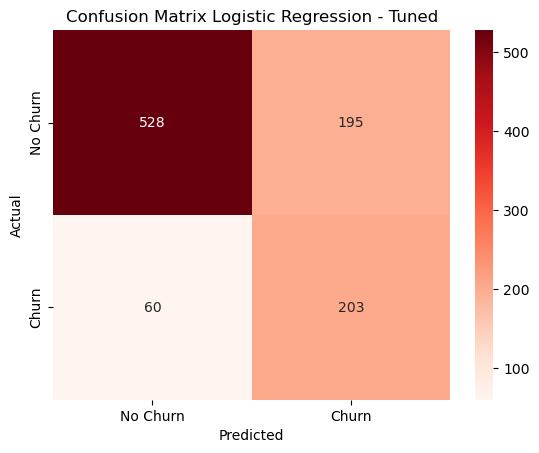

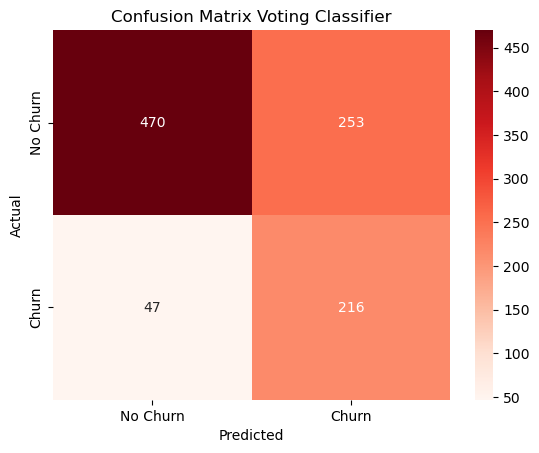

In [34]:
from sklearn.metrics import confusion_matrix

for model_name, best_model in best_models.items():
    y_test_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {model_name} - Tuned')
    plt.show()

# voting classifier
y_probs = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Voting Classifier')
plt.show()

In [35]:
C_retention = 10  # Cost of retaining a customer
C_acquisition = 50  # Cost of acquiring a new customer

confusion_matrices = {
    'AdaBoost': [404, 319, 31, 232],
    'Naive Bayes': [468, 255, 47, 216],
    'K-Nearest Neighbors': [530, 193, 71, 192],
    'Support Vector Machine': [469, 254, 47, 216],
    'Logistic Regression': [528, 195, 60, 203],
    'Voting Classifier': [470, 253, 47, 216],
}

costs = {}
for model_name, cm in confusion_matrices.items():
    TN, FP, FN, TP = cm
    total_cost = (FP * C_retention) + (FN * C_acquisition)
    costs[model_name] = total_cost

costs

{'AdaBoost': 4740,
 'Naive Bayes': 4900,
 'K-Nearest Neighbors': 5480,
 'Support Vector Machine': 4890,
 'Logistic Regression': 4950,
 'Voting Classifier': 4880}

> Notes:
>
> Dengan asumsi bahwa biaya akuisisi adalah **5x lebih besar** dari biaya retensi, kita dapat menetapkan biaya dummy untuk upaya retensi yaitu ($10) dan biaya akuisisi yaitu ($50).
>
> Setelah menghitung total biaya yang terkait dengan masing-masing model, berikut adalah hasilnya:
>
> | Model                    | Total Biaya | Dari Pelanggan yang Tidak Churn (FP) | Dari Pelanggan yang Churn (FN) |
> |--------------------------|-------------|--------------------------------------|--------------------------------|
> | **AdaBoost**             | $4,740      | $3,190 (319 x $10)                  | $1,550 (31 x $50)              |
> | **Naive Bayes**          | $4,900      | $2,550 (255 x $10)                  | $2,350 (47 x $50)              |
> | **K-Nearest Neighbors**  | $5,480      | $1,930 (193 x $10)                  | $3,550 (71 x $50)              |
> | **Support Vector Machine**| $4,890      | $2,540 (254 x $10)                  | $2,350 (47 x $50)              |
> | **Logistic Regression**   | $4,950      | $1,950 (195 x $10)                  | $3,000 (60 x $50)              |
> | **Voting Classifier**     | $4,880      | $2,530 (253 x $10)                  | $2,350 (47 x $50)              |
>
> Dari analisis ini, **AdaBoost** adalah model paling efisien dengan total biaya terendah sebesar **$4,740**. Rincian biaya adalah sebagai berikut:
> - Dari pelanggan yang **tidak churn** (terprediksi churn padahal tidak, tetapi mendapatkan retention efforts), model ini menghabiskan **$3,190** untuk **319 pelanggan**.
> - Dari pelanggan yang **churn** (terprediksi tidak churn padahal churn, sehingga mengharuskan untuk mencari pelanggan baru), model ini menanggung biaya **$1,550** untuk **31 pelanggan**.
>
> Model lain seperti **Naive Bayes**, **Support Vector Machine**, dan **Voting Classifier** menunjukkan biaya yang sama, tetapi lebih tinggi daripada AdaBoost, dengan rincian serupa yang menunjukkan pengeluaran yang kurang efisien.
>
> Dengan mempertimbangkan biaya akuisisi yang lebih tinggi daripada biaya retensi, **AdaBoost** menjadi pilihan terbaik untuk strategi bisnis yang berfokus pada pengurangan churn dan penghematan biaya.

In [36]:
# save adaboost classification report

y_test_pred_adaboost = best_models['AdaBoost'].predict(X_test)
final_model_report = classification_report(y_test, y_test_pred_adaboost)

> Notes:
> - Sedikit mengenai cara kerja AdaBoost:
>
>    Model ini adalah algoritma ensemble yang menggabungkan beberapa weak learners (seperti `Decision Tree`) untuk membentuk model yang lebih kuat secara ber-iterasi. **AdaBoost memberikan bobot lebih pada kesalahan klasifikasi dari iterasi sebelumnya**, sehingga model dapat fokus memperbaiki kesalahan yang ada. 
>
>    **Kinerjanya baik pada dataset yang tidak seimbang** karena dapat secara efektif **mengidentifikasi dan memprioritaskan kelas minoritas** dan memungkinkan deteksi churn yang akurat meskipun terdapat lebih sedikit data. Setelah melakukan hyperparameter tuning, AdaBoost menunjukkan performa terbaik dalam prediksi churn pelanggan.

#### **Feature Evaluation**

                                 Feature  Importance
26               cat_ord__TenureCategory        0.30
1                            num__tenure        0.12
3                 cat_nom__Dependents_No        0.10
0                    num__MonthlyCharges        0.10
4                cat_nom__Dependents_Yes        0.08
12  cat_nom__InternetService_Fiber optic        0.04
2           num__TotalAdditionalServices        0.04
21            cat_nom__Contract_One year        0.04
25              cat_ord__ChargesCategory        0.02
7            cat_nom__OnlineSecurity_Yes        0.02


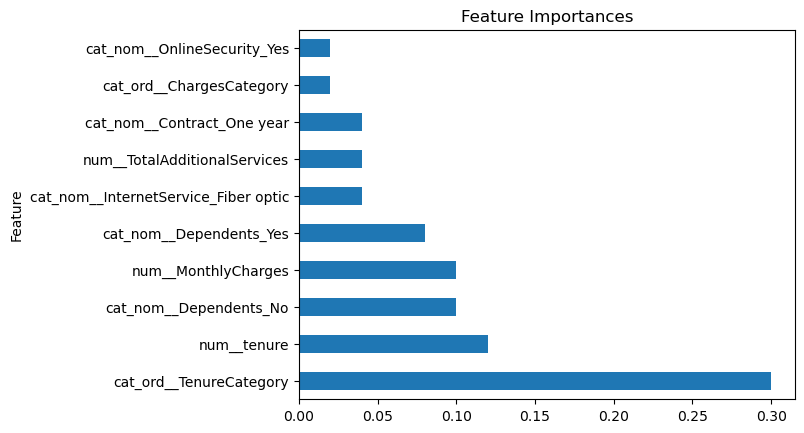

In [37]:
# Create the pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2002)),
    ('classifier', AdaBoostClassifier(n_estimators=50))
])

pipeline.fit(X_train, y_train)

# Access the AdaBoost model from the pipeline
ada_boost_model = pipeline.named_steps['classifier']

# Get feature importances
feature_importances = ada_boost_model.feature_importances_

# Get feature names after preprocessing
all_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(10)

# Print the feature importances
print(importances_df)

# Optional: Plot feature importances
importances_df.plot(x='Feature', y='Importance', kind='barh', title='Feature Importances', legend=False)
plt.show()


> Notes:
>
> 1. **Tenure Category (30%)**: Kategori masa pelanggan merupakan faktor paling penting, menunjukkan bahwa lama berlangganan sangat berpengaruh terhadap kemungkinan churn. Mempertahankan pelanggan lama dapat mengurangi risiko kehilangan pelanggan.
>
> 2. **Monthly Charges (10%)**: Biaya bulanan berkontribusi signifikan, mengindikasikan bahwa tarif yang lebih tinggi dapat mendorong churn. Strategi penawaran harga yang kompetitif bisa membantu mempertahankan pelanggan.
>
> 3. **Dependents (No) (10%)**: Pelanggan tanpa tanggungan menunjukkan pola churn yang lebih tinggi. Memahami segmen ini dapat membantu dalam merancang program retensi yang lebih efektif.

#### **Saving Model**

In [38]:
pipeline.fit(X, y)

import pickle

# Save the model to a file
with open('final_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)

#### **Limitation**

In [39]:
# numerical limitations
print('Numerical Limitations:')
display(X.describe())

# categorical limitations
print('Categorical Limitations:')
categorical_summary_list = []

for column in X.select_dtypes(include=['object', 'category']):
    unique_counts = X[column].value_counts()
    unique_values = ', '.join([f"{value} ({count})" for value, count in unique_counts.items()])
    categorical_summary_list.append({
        'Feature': column,
        'Allowed Values For Best Estimate': unique_values
    })

categorical_summary = pd.DataFrame(categorical_summary_list)
categorical_summary

Numerical Limitations:


,tenure,MonthlyCharges,TotalAdditionalServices
count,4930.000000,4930.000000,4930.000000
mean,32.401217,64.883032,1.266126
std,24.501193,29.923960,1.285786
min,0.000000,18.800000,0.000000
25%,9.000000,37.050000,0.000000
50%,29.000000,70.350000,1.000000
75%,55.000000,89.850000,2.000000
max,72.000000,118.650000,4.000000


Categorical Limitations:


,Feature,Allowed Values For Best Estimate
0,Dependents,"No (3446), Yes (1484)"
1,OnlineSecurity,"No (2445), Yes (1433), No internet service (1052)"
2,OnlineBackup,"No (2172), Yes (1706), No internet service (1052)"
3,InternetService,"Fiber optic (2172), DSL (1706), No (1052)"
4,DeviceProtection,"No (2186), Yes (1692), No internet service (1052)"
5,TechSupport,"No (2467), Yes (1411), No internet service (1052)"
6,Contract,"Month-to-month (2721), Two year (1157), One ye..."
7,PaperlessBilling,"Yes (2957), No (1973)"
8,TenureCategory,"Short-Term (1308), Very Long-Term (1232), Long..."
9,ChargesCategory,"Medium (1235), Low (1233), Very High (1232), H..."


> Notes:
>
> Dapat dikatakan bahwa model dapat memprediksi dengan akurat (sesuai performa pada tahap-tahap sebelumnya) data-data yang memiliki spesifikasi seperti:
>
> 1. **Rentang Data Numerik**:
>   - **Tenure**: Rentang masa pelanggan antara 0 hingga 72 bulan, dengan rata-rata sekitar 32,4 bulan.
>
>   - **Biaya Bulanan**: Biaya bulanan berkisar antara $18,80 hingga $118,65, dengan rata-rata $64,88.
>
>   - **Total Layanan Tambahan**: Rentang 0 hingga 4 layanan tambahan selain langganan internet.
>
> 2. **Rentang Data Kategorikal**:
>   - Model hanya dapat memprediksi dengan baik jika data kategorikal pada dataset yang akan diprediksi sesuai dengan batasan data yang dipelajari oleh model seperti pada kolom `Allowed Values` diatas.

## **Conclusion & Recommendation**

In [40]:
print('Final Model (AdaBoost Tuned): \n', final_model_report)

Final Model (AdaBoost Tuned): 
               precision    recall  f1-score   support

           0       0.93      0.56      0.70       723
           1       0.42      0.88      0.57       263

    accuracy                           0.65       986
   macro avg       0.67      0.72      0.63       986
weighted avg       0.79      0.65      0.66       986



#### **Conclusion**

**Model AdaBoost** dengan feature selection sebanyak 15 (**SelectKBest**) dan **SMOTE sampling** menunjukkan performa yang menjanjikan dalam memprediksi kemungkinan pelanggan akan churn. Setelah melalui tahap data preprocessing dan hyperparameter tuning, model ini hanya menggunakan fitur-fitur yang paling relevan dan mencapai **nilai recall sebesar 88%**. Nilai ini menunjukkan bahwa model mampu memprioritaskan pelanggan yang churn untuk **meminimalisir aquisition cost dan churn rate** yang merupakan fokus pada model ini.


#### **Business Insights**

Dari sisi bisnis, penggunaan model AdaBoost telah memberikan dampak positif yang signifikan. Dengan mengidentifikasi pelanggan yang berisiko churn, perusahaan Telco dapat mengurangi biaya akuisisi dan mempertahankan pelanggan lebih efisien. 

Asumsikan bahwa terdapat 100 customer dengan proporsi 50% churn dan 50% tidak churn. Asumsikan pula kalau retention cost = $10 dan aquisition cost = $50. 

**Tanpa model**: 

Dalam skenario ini, kita mengasumsikan semua pelanggan yang churn perlu di-akuisisi.

- **Pelanggan yang Churn**: 50
- **Biaya Akuisisi**:
  - 50 pelanggan yang churn * $50 = **$2,500**

- **Total Biaya Tanpa Model**: **$2,500**

**Dengan model**:

1. **False Negatives (FN)**:
   - FN = Pelanggan yang Churn - TP = 50 - 44 = **6** pelanggan yang churn tetapi tidak diprediksi sebagai churn.

2. **False Positives (FP)**:
   - FP = (TP / Precision) - TP = (44 / 0.42) - 44 ≈ **62** pelanggan yang salah diidentifikasi sebagai churn.

**Perhitungan Biaya:**

1. **Biaya Churn (FN)**:
   - Biaya untuk memperoleh pelanggan baru bagi 6 pelanggan yang churn yang tidak teridentifikasi:
   - Biaya FN = 6 pelanggan * $50 = **$300**.

2. **Biaya Retensi untuk FP**:
   - Biaya untuk mempertahankan 62 pelanggan yang tidak churn tetapi salah diprediksi sebagai churn:
   - Biaya FP = 62 pelanggan * $10 = **$620**.

- **Total Biaya = Biaya FN + Biaya FP**
- Total Biaya = $300 (biaya akuisisi untuk churn yang terlewat) + $620 (biaya retensi untuk yang salah diprediksi) = **$920**.

Dengan demikian, implementasi model AdaBoost dapat **mengurangi kerugian kepada perusahaan sebesar $1580 atau 63%** sehingga memberikan kontribusi positif terhadap kinerja bisnis Telco.

#### **Recommendation**

##### **Rekomendasi Bisnis:**

1. **Fokus pada Retensi Pelanggan Lama**:
   - **Tujuan**: Mengurangi risiko churn dengan memberikan nilai lebih kepada pelanggan yang setia.

2. **Penyesuaian Harga dan Penawaran**:
   - **Tujuan**: Menarik pelanggan yang sensitif terhadap harga dan mempertahankan pelanggan yang mungkin merasa biaya mereka terlalu tinggi.

3. **Segmentasi Pelanggan Tanpa Tanggungan**:
   - **Tujuan**: Mengurangi churn di segmen ini dengan memberikan solusi yang sesuai dengan kebutuhan spesifik mereka, sehingga meningkatkan loyalitas dan kepuasan pelanggan.

##### **Rekomendasi Model:**

1. **Penerapan Hyperparameter Tuning yang Lebih Mendalam**:

   Gunakan kombinasi hyperparameter yang berbeda dan metode sampling selain `SMOTE`. Metode feature selection selain `SelectKBest` juga mungkin memberikan hasil yang lebih baik. 
   
   Coba gunakan juga `RandomSearchCV` atau teknik selain `GridSearchCV` untuk menemukan kombinasi parameter optimal pada model. Untuk model voting, dapat mencoba dilakukan tuning, serta mencoba mencari `treshold label` terbaik menggunakan tuning.

2. **Analisis Kesalahan**:

   Lakukan `analisis mendalam terhadap prediksi yang salah` untuk memahami pola churn yang tidak teridentifikasi. Harapannya dapat nenggunakan wawasan ini untuk memperbaiki model dan meningkatkan akurasi.

3. **Penggunaan Fitur Tambahan**:

   Identifikasi dan tambahkan fitur tambahan yang relevan seperti `Riwayat Pembayaran`, `Feedback atau Survey Pelanggan`, `Promosi yang Diambil`, dan lains sebagainya. Serta pertimbangkan teknik preprocessing yang lebih canggih guna eningkatkan representasi data dalam model untuk hasil prediksi yang lebih baik.
